### Домашнее задание к уроку 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 
    1. бустинг, 
    2. логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
    
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

5. (опционально) Еще раз провести оценку экономической эффективности

Набор данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# словарь для записи результатов
models_results = {'Model': [], 'Best Threshold': [], 'F-Score': [], 'Precision': [], 'Recall': []}

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [3]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

# зададим списки признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# сделаем трансформер под каждый список (в цикле):
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler()) # для лог.регрессии
            ])
    final_transformers.append((cont_col, cont_transformer))
    
# объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

### Модель RandomForestClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

pipeline_RF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

# обучим наш пайплайн
pipeline_RF.fit(X_train, y_train)

# наши прогнозы для тестовой выборки
preds = pipeline_RF.predict_proba(X_test)[:, 1]

# посчитаем метрики, определим порог и расставим метки классов относительно порога:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

models_results['Model'].append('RandomForestClassifier')
models_results['Best Threshold'].append(round(thresholds[ix], 2))
models_results['F-Score'].append(round(fscore[ix], 2))
models_results['Precision'].append(round(precision[ix], 2))
models_results['Recall'].append(round(recall[ix], 2))

pd.DataFrame(data=models_results)

,Model,Best Threshold,F-Score,Precision,Recall
0,RandomForestClassifier,0.38,0.64,0.65,0.63


Построим матрицу ошибок:

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


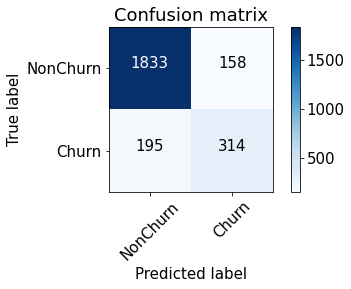

In [7]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Оценим экономический эффект:

На удержание одного пользователя у нас уйдет 1 доллар. 
При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара.

In [8]:
retain_sum = (cnf_matrix[0][1] + cnf_matrix[1][1]) * 1
income = cnf_matrix[1][1] * 2
income - retain_sum

156

### Модель CatBoostClassifier

In [9]:
from catboost import CatBoostClassifier

pipeline_CB = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42)),
])

# обучим наш пайплайн
pipeline_CB.fit(X_train, y_train)

# наши прогнозы для тестовой выборки
preds = pipeline_CB.predict_proba(X_test)[:, 1]

# посчитаем метрики, определим порог и расставим метки классов относительно порога:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

models_results['Model'].append('CatBoostClassifier')
models_results['Best Threshold'].append(round(thresholds[ix], 2))
models_results['F-Score'].append(round(fscore[ix], 2))
models_results['Precision'].append(round(precision[ix], 2))
models_results['Recall'].append(round(recall[ix], 2))

pd.DataFrame(data=models_results)

Learning rate set to 0.024355
0:	learn: 0.6726374	total: 146ms	remaining: 2m 26s
1:	learn: 0.6548174	total: 154ms	remaining: 1m 16s
2:	learn: 0.6405685	total: 159ms	remaining: 52.9s
3:	learn: 0.6237743	total: 164ms	remaining: 40.9s
4:	learn: 0.6080844	total: 168ms	remaining: 33.5s
5:	learn: 0.5929243	total: 172ms	remaining: 28.5s
6:	learn: 0.5787577	total: 178ms	remaining: 25.2s
7:	learn: 0.5659958	total: 184ms	remaining: 22.8s
8:	learn: 0.5556154	total: 190ms	remaining: 20.9s
9:	learn: 0.5441443	total: 195ms	remaining: 19.3s
10:	learn: 0.5348181	total: 200ms	remaining: 18s
11:	learn: 0.5257042	total: 205ms	remaining: 16.9s
12:	learn: 0.5169250	total: 209ms	remaining: 15.9s
13:	learn: 0.5074365	total: 213ms	remaining: 15s
14:	learn: 0.4985522	total: 219ms	remaining: 14.4s
15:	learn: 0.4914367	total: 223ms	remaining: 13.7s
16:	learn: 0.4826085	total: 227ms	remaining: 13.1s
17:	learn: 0.4757232	total: 232ms	remaining: 12.6s
18:	learn: 0.4680217	total: 237ms	remaining: 12.2s
19:	learn: 0.

166:	learn: 0.3188395	total: 909ms	remaining: 4.53s
167:	learn: 0.3187127	total: 914ms	remaining: 4.53s
168:	learn: 0.3185197	total: 920ms	remaining: 4.52s
169:	learn: 0.3182822	total: 926ms	remaining: 4.52s
170:	learn: 0.3181452	total: 931ms	remaining: 4.51s
171:	learn: 0.3180427	total: 935ms	remaining: 4.5s
172:	learn: 0.3178044	total: 942ms	remaining: 4.5s
173:	learn: 0.3176387	total: 949ms	remaining: 4.51s
174:	learn: 0.3174666	total: 957ms	remaining: 4.51s
175:	learn: 0.3173161	total: 962ms	remaining: 4.5s
176:	learn: 0.3170997	total: 968ms	remaining: 4.5s
177:	learn: 0.3170085	total: 975ms	remaining: 4.5s
178:	learn: 0.3167982	total: 981ms	remaining: 4.5s
179:	learn: 0.3165682	total: 987ms	remaining: 4.5s
180:	learn: 0.3164511	total: 995ms	remaining: 4.5s
181:	learn: 0.3162469	total: 1s	remaining: 4.5s
182:	learn: 0.3160913	total: 1.01s	remaining: 4.5s
183:	learn: 0.3159072	total: 1.01s	remaining: 4.5s
184:	learn: 0.3157721	total: 1.02s	remaining: 4.51s
185:	learn: 0.3156505	tota

362:	learn: 0.2926185	total: 1.81s	remaining: 3.17s
363:	learn: 0.2925322	total: 1.81s	remaining: 3.17s
364:	learn: 0.2924112	total: 1.82s	remaining: 3.17s
365:	learn: 0.2922008	total: 1.82s	remaining: 3.16s
366:	learn: 0.2920425	total: 1.83s	remaining: 3.16s
367:	learn: 0.2919367	total: 1.84s	remaining: 3.16s
368:	learn: 0.2918725	total: 1.84s	remaining: 3.15s
369:	learn: 0.2917870	total: 1.85s	remaining: 3.15s
370:	learn: 0.2916162	total: 1.85s	remaining: 3.14s
371:	learn: 0.2915264	total: 1.86s	remaining: 3.14s
372:	learn: 0.2913641	total: 1.86s	remaining: 3.13s
373:	learn: 0.2912911	total: 1.87s	remaining: 3.13s
374:	learn: 0.2912251	total: 1.87s	remaining: 3.12s
375:	learn: 0.2910964	total: 1.88s	remaining: 3.12s
376:	learn: 0.2910322	total: 1.88s	remaining: 3.11s
377:	learn: 0.2909866	total: 1.89s	remaining: 3.1s
378:	learn: 0.2908745	total: 1.89s	remaining: 3.1s
379:	learn: 0.2907327	total: 1.9s	remaining: 3.09s
380:	learn: 0.2906548	total: 1.9s	remaining: 3.09s
381:	learn: 0.29

554:	learn: 0.2704050	total: 2.71s	remaining: 2.17s
555:	learn: 0.2702776	total: 2.71s	remaining: 2.17s
556:	learn: 0.2701332	total: 2.72s	remaining: 2.16s
557:	learn: 0.2700162	total: 2.72s	remaining: 2.16s
558:	learn: 0.2698756	total: 2.73s	remaining: 2.15s
559:	learn: 0.2697172	total: 2.73s	remaining: 2.15s
560:	learn: 0.2696594	total: 2.74s	remaining: 2.14s
561:	learn: 0.2695824	total: 2.74s	remaining: 2.14s
562:	learn: 0.2694121	total: 2.75s	remaining: 2.13s
563:	learn: 0.2693203	total: 2.75s	remaining: 2.13s
564:	learn: 0.2692196	total: 2.76s	remaining: 2.12s
565:	learn: 0.2691167	total: 2.76s	remaining: 2.12s
566:	learn: 0.2689971	total: 2.77s	remaining: 2.11s
567:	learn: 0.2689273	total: 2.77s	remaining: 2.11s
568:	learn: 0.2687912	total: 2.78s	remaining: 2.1s
569:	learn: 0.2686687	total: 2.78s	remaining: 2.1s
570:	learn: 0.2685901	total: 2.79s	remaining: 2.09s
571:	learn: 0.2684870	total: 2.79s	remaining: 2.09s
572:	learn: 0.2683967	total: 2.8s	remaining: 2.08s
573:	learn: 0.2

724:	learn: 0.2537076	total: 3.43s	remaining: 1.3s
725:	learn: 0.2536236	total: 3.44s	remaining: 1.3s
726:	learn: 0.2535437	total: 3.44s	remaining: 1.29s
727:	learn: 0.2534612	total: 3.45s	remaining: 1.29s
728:	learn: 0.2533808	total: 3.45s	remaining: 1.28s
729:	learn: 0.2532684	total: 3.46s	remaining: 1.28s
730:	learn: 0.2531838	total: 3.46s	remaining: 1.27s
731:	learn: 0.2530769	total: 3.46s	remaining: 1.27s
732:	learn: 0.2529907	total: 3.47s	remaining: 1.26s
733:	learn: 0.2528853	total: 3.47s	remaining: 1.26s
734:	learn: 0.2527116	total: 3.47s	remaining: 1.25s
735:	learn: 0.2526468	total: 3.48s	remaining: 1.25s
736:	learn: 0.2525850	total: 3.48s	remaining: 1.24s
737:	learn: 0.2524876	total: 3.49s	remaining: 1.24s
738:	learn: 0.2523773	total: 3.49s	remaining: 1.23s
739:	learn: 0.2522772	total: 3.49s	remaining: 1.23s
740:	learn: 0.2521950	total: 3.5s	remaining: 1.22s
741:	learn: 0.2521092	total: 3.5s	remaining: 1.22s
742:	learn: 0.2520105	total: 3.5s	remaining: 1.21s
743:	learn: 0.251

892:	learn: 0.2396118	total: 4.15s	remaining: 498ms
893:	learn: 0.2395218	total: 4.16s	remaining: 493ms
894:	learn: 0.2394330	total: 4.17s	remaining: 489ms
895:	learn: 0.2393283	total: 4.17s	remaining: 484ms
896:	learn: 0.2392039	total: 4.18s	remaining: 480ms
897:	learn: 0.2391078	total: 4.18s	remaining: 475ms
898:	learn: 0.2389811	total: 4.18s	remaining: 470ms
899:	learn: 0.2388662	total: 4.19s	remaining: 466ms
900:	learn: 0.2388047	total: 4.19s	remaining: 461ms
901:	learn: 0.2387421	total: 4.2s	remaining: 456ms
902:	learn: 0.2386572	total: 4.2s	remaining: 451ms
903:	learn: 0.2385840	total: 4.21s	remaining: 447ms
904:	learn: 0.2385132	total: 4.21s	remaining: 442ms
905:	learn: 0.2384326	total: 4.21s	remaining: 437ms
906:	learn: 0.2383329	total: 4.22s	remaining: 433ms
907:	learn: 0.2382519	total: 4.22s	remaining: 428ms
908:	learn: 0.2381939	total: 4.23s	remaining: 423ms
909:	learn: 0.2381303	total: 4.23s	remaining: 419ms
910:	learn: 0.2380475	total: 4.24s	remaining: 414ms
911:	learn: 0.

,Model,Best Threshold,F-Score,Precision,Recall
0,RandomForestClassifier,0.38,0.64,0.65,0.63
1,CatBoostClassifier,0.38,0.64,0.66,0.63


Confusion matrix, without normalization
[[1827  164]
 [ 190  319]]


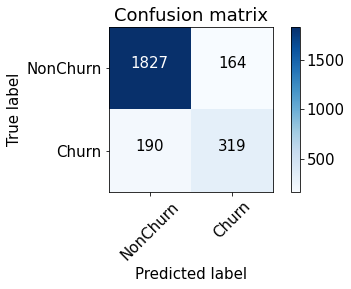

In [10]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Оценим экономический эффект:

На удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара.

In [11]:
retain_sum = (cnf_matrix[0][1] + cnf_matrix[1][1]) * 1
income = cnf_matrix[1][1] * 2
income - retain_sum

155

### Модель LogisticRegression

In [12]:
from sklearn.linear_model import LogisticRegression

pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 0.1, random_state = 42)),
])

# обучим наш пайплайн
pipeline_LR.fit(X_train, y_train)

# наши прогнозы для тестовой выборки
preds = pipeline_LR.predict_proba(X_test)[:, 1]

# посчитаем метрики, определим порог и расставим метки классов относительно порога:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

models_results['Model'].append('LogisticRegression')
models_results['Best Threshold'].append(round(thresholds[ix], 2))
models_results['F-Score'].append(round(fscore[ix], 2))
models_results['Precision'].append(round(precision[ix], 2))
models_results['Recall'].append(round(recall[ix], 2))

pd.DataFrame(data=models_results)

,Model,Best Threshold,F-Score,Precision,Recall
0,RandomForestClassifier,0.38,0.64,0.65,0.63
1,CatBoostClassifier,0.38,0.64,0.66,0.63
2,LogisticRegression,0.29,0.51,0.47,0.56


Confusion matrix, without normalization
[[1664  327]
 [ 224  285]]


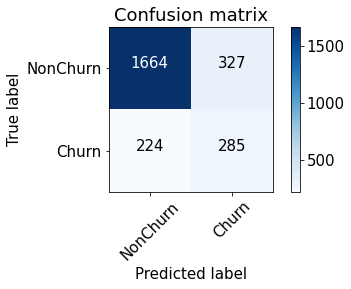

In [13]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Оценим экономический эффект:

На удержание одного пользователя у нас уйдет 1 доллар. 
При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара.

In [14]:
retain_sum = (cnf_matrix[0][1] + cnf_matrix[1][1]) * 1
income = cnf_matrix[1][1] * 2
income - retain_sum

-42

In [15]:
pd.DataFrame(data=models_results)

,Model,Best Threshold,F-Score,Precision,Recall
0,RandomForestClassifier,0.38,0.64,0.65,0.63
1,CatBoostClassifier,0.38,0.64,0.66,0.63
2,LogisticRegression,0.29,0.51,0.47,0.56


Модель LogisticRegression хуже всего справилась с задачей оттока.
RandomForestClassifier и CatBoostClassifier показали ~ одинаковые результаты, т.к. на уроке делали подбор параметров к модели RandomForestClassifier, в ДЗ подберем параметры к модели CatBoostClassifier с помощью GridSearch.

In [16]:
from sklearn.model_selection import GridSearchCV

# сетка с параметрами
params={'classifier__iterations': [30, 50, 100],
        'classifier__learning_rate': [0.01, 0.02, 0.03],
        'classifier__depth': [6, 10]}

In [17]:
%%time

# запускаем перебор:
grid = GridSearchCV(pipeline_CB, param_grid=params, cv=6, refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 0 ns


Лучшие параметны по результатам GridSearchCV: iterations=100, learning_rate=0.03, depth=10.

In [18]:
# обучим модель уже с новыми параметрами
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(iterations=100, learning_rate=0.03, depth=10, random_state = 42)),
])

# обучим наш пайплайн
pipeline.fit(X_train, y_train)

# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]

# посчитаем метрики, определим порог и расставим метки классов относительно порога:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

models_results['Model'].append('CatBoostClassifier with params')
models_results['Best Threshold'].append(round(thresholds[ix], 2))
models_results['F-Score'].append(round(fscore[ix], 2))
models_results['Precision'].append(round(precision[ix], 2))
models_results['Recall'].append(round(recall[ix], 2))

pd.DataFrame(data=models_results)

0:	learn: 0.6655089	total: 20.1ms	remaining: 1.99s
1:	learn: 0.6403214	total: 39.1ms	remaining: 1.92s
2:	learn: 0.6198065	total: 43.8ms	remaining: 1.42s
3:	learn: 0.6007900	total: 61.3ms	remaining: 1.47s
4:	learn: 0.5797204	total: 79.8ms	remaining: 1.51s
5:	learn: 0.5605620	total: 99.9ms	remaining: 1.56s
6:	learn: 0.5444399	total: 118ms	remaining: 1.57s
7:	learn: 0.5299824	total: 137ms	remaining: 1.57s
8:	learn: 0.5177367	total: 141ms	remaining: 1.42s
9:	learn: 0.5044460	total: 159ms	remaining: 1.43s
10:	learn: 0.4920253	total: 178ms	remaining: 1.44s
11:	learn: 0.4802589	total: 197ms	remaining: 1.44s
12:	learn: 0.4694880	total: 219ms	remaining: 1.47s
13:	learn: 0.4603474	total: 225ms	remaining: 1.38s
14:	learn: 0.4513577	total: 232ms	remaining: 1.31s
15:	learn: 0.4421376	total: 250ms	remaining: 1.31s
16:	learn: 0.4353166	total: 268ms	remaining: 1.31s
17:	learn: 0.4277140	total: 287ms	remaining: 1.31s
18:	learn: 0.4204809	total: 306ms	remaining: 1.3s
19:	learn: 0.4174935	total: 309ms	re

,Model,Best Threshold,F-Score,Precision,Recall
0,RandomForestClassifier,0.38,0.64,0.65,0.63
1,CatBoostClassifier,0.38,0.64,0.66,0.63
2,LogisticRegression,0.29,0.51,0.47,0.56
3,CatBoostClassifier with params,0.32,0.65,0.62,0.68


Confusion matrix, without normalization
[[1783  208]
 [ 166  343]]


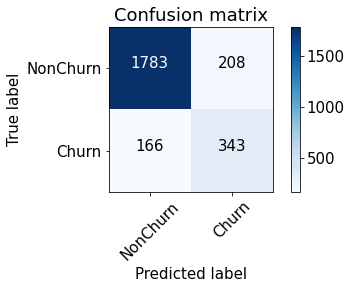

In [19]:
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Модель CatBoostClassifier с подобранными параметрами лучше предсказала отток TP и меньше ошиблась в FN, чем все предыдущие модели.

In [20]:
retain_sum = (cnf_matrix[0][1] + cnf_matrix[1][1]) * 1
income = cnf_matrix[1][1] * 2
income - retain_sum

135